<a href="https://colab.research.google.com/github/lidwinaput/psia2023/blob/main/PSIA2023_CMA_Final_Project_US_Migration_1945.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual Assignment - Computational Media Analysis

- Corpus preparation [6 points]
- Lexical extraction [6 pts]
- Temporal analysis [6 pts]
- Topic modelling [6 pts]


### Library pre-loading
You will most likely need to load a series of libraries to complete the assignment
If a library is missing. Remember it is easy to install it using the following syntax:

```python
!pip install library_name
```

or alternatively depending on your system
```python
!pip3 install library_name
```


In [ ]:
!pip install spacy

In [ ]:
#please make sure this executes properly before moving forward.
import spacy
import pandas as pd

import json
import spacy
import requests
import random
import time

import spacy
import tqdm
from collections import Counter

import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Corpus preparation
📰 Let's download data from the New York Times API.

Donwload a corpus from the NYT API.
- You need to specify a search query, and optionnaly a meaningful time range (please remember that the data will be collected from the most recent articles to the oldest)
- Make sure to download a corpus composed of at least 1.000 articles.
- Please write a short text explaining why you think this corpus (search query) is interesting to investigate.
- And make sure to save the data as a csv file. Please, first use use the consolidate_corpus function which turns the outcome of the search_nyt_articles function into a dataframe. This dataframe can then later be saved as a csv file using the syntax:
```python
df.to_csv('my_corpus.csv',index=False)
```
- At a later stage you can open your corpus using the following syntax (no need to download data from the API again)
```python
df=pd.read_csv('my_corpus.csv')
```
- Display 5 random rows in the dataframe.

In [ ]:
# First copy and paste your API key
my_api_key="yosKOZmMYbCmwqiQhIx6bv6NkHx1aeA2"

In [ ]:
import requests
def number_of_articles(api_key,keyword,begin_date="19450101",end_date="20240101"):
    url_query = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?fq={keyword}&begin_date={begin_date}&end_date={end_date}&api-key={api_key}"
    print (url_query)
    res = requests.get(url_query)
    json_res = res.json()
    hits = json_res["response"]["meta"]["hits"]
    return hits

print(number_of_articles(api_key=my_api_key,keyword='Immigration AND "United States"'))


https://api.nytimes.com/svc/search/v2/articlesearch.json?fq=Immigration AND "United States"&begin_date=19450101&end_date=20240101&api-key=yosKOZmMYbCmwqiQhIx6bv6NkHx1aeA2
38891


In [ ]:
## why the corpus is interesting to investigate
## to view the discourse that appears on trump's presidency and border policy/migration-related events that occured during his time

In [ ]:

## define a function to interact with the NYT API
def search_nyt_articles(api_key,keyword,max_pages,begin_date="19450101",end_date="20240101"):
    #There are two rate limits per API: 500 requests per day and 5 requests per minute. You should sleep 12 seconds between calls to avoid hitting the per minute rate limit. If you need a higher rate limit, please contact us at code@nytimes.com.


    """Returns a list of articles for a given query

    Parameters:
    api_key (str): your NYT api key
    keyword (str): a keyword by which you want to filter the articles
    begin_date (str): a begin date in the format "YYYYMMDD"
    end_date (str): a begin date in the format "YYYYMMDD"
    pages (int): how many pages to run through (you get 10 articles per page)

    Returns:
    docs (list): a list of articles as dictionaries
    """

    docs = []

    for i in range(max_pages):

        api = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?q={keyword}&begin_date={begin_date}&end_date={end_date}&page={i+1}&api-key={api_key}"
        print (api)
        response = requests.get(api)
        data = response.json()
        try:
            docs.extend(data['response']['docs'])
        except:
            return docs
        time.sleep(12)
    return docs

## download some articles about a keyword from the last 10 days
articles = search_nyt_articles(api_key=my_api_key,
                                 keyword="Immigration and 'United States' ",
                                 begin_date="19450101",
                                 max_pages=500)

https://api.nytimes.com/svc/search/v2/articlesearch.json?q= 'Immigration' and 'United States' &begin_date=19450101&end_date=20240101&page=1&api-key=yosKOZmMYbCmwqiQhIx6bv6NkHx1aeA2
https://api.nytimes.com/svc/search/v2/articlesearch.json?q= 'Immigration' and 'United States' &begin_date=19450101&end_date=20240101&page=2&api-key=yosKOZmMYbCmwqiQhIx6bv6NkHx1aeA2
https://api.nytimes.com/svc/search/v2/articlesearch.json?q= 'Immigration' and 'United States' &begin_date=19450101&end_date=20240101&page=3&api-key=yosKOZmMYbCmwqiQhIx6bv6NkHx1aeA2
https://api.nytimes.com/svc/search/v2/articlesearch.json?q= 'Immigration' and 'United States' &begin_date=19450101&end_date=20240101&page=4&api-key=yosKOZmMYbCmwqiQhIx6bv6NkHx1aeA2
https://api.nytimes.com/svc/search/v2/articlesearch.json?q= 'Immigration' and 'United States' &begin_date=19450101&end_date=20240101&page=5&api-key=yosKOZmMYbCmwqiQhIx6bv6NkHx1aeA2
https://api.nytimes.com/svc/search/v2/articlesearch.json?q= 'Immigration' and 'United States' &

ConnectionError: HTTPSConnectionPool(host='api.nytimes.com', port=443): Max retries exceeded with url: /svc/search/v2/articlesearch.json?q=%20'Immigration'%20and%20'United%20States'%20&begin_date=19450101&end_date=20240101&page=81&api-key=yosKOZmMYbCmwqiQhIx6bv6NkHx1aeA2 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x17dabc2d0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [ ]:
#This function will turn the generated set of articles into a dataframe containing the headline, leadparagraphs and date of each article.
#print (article['headline']['main'],article['pub_date'])

def consolidate_corpus(articles):
    docs=[]
    for article in articles:
        docs.append([article['headline']['main'],article['lead_paragraph'],article['pub_date']])
    corpus=pd.DataFrame(docs,columns=['headline','leadparagraph','date'])
    return corpus
corpus = consolidate_corpus(articles)

In [ ]:
corpus.head()

,headline,leadparagraph,date
0,Trumpism Without Borders,America is embedded in a world that is trouble...,2021-06-16T09:02:41+0000
1,Trump: Closing Borders Will Reduce ‘Mass Globa...,The U.S. Coronavirus Task Force held a news co...,2020-03-20T15:30:52+0000
2,Biden faces pressure to stop Trump-era border ...,President Biden is coming under increasing pre...,2021-05-25T12:29:22+0000
3,Biden Administration Forces Out Trump-Era Bord...,WASHINGTON — The Biden administration is forci...,2021-06-24T01:47:51+0000
4,Trump-Era Border Restrictions Are in Place as ...,WASHINGTON — One of the most expansive immigra...,2022-12-20T22:25:10+0000


In [ ]:
corpus.sort_index()

,headline,leadparagraph,date
0,Trumpism Without Borders,America is embedded in a world that is trouble...,2021-06-16T09:02:41+0000
1,Trump: Closing Borders Will Reduce ‘Mass Globa...,The U.S. Coronavirus Task Force held a news co...,2020-03-20T15:30:52+0000
2,Biden faces pressure to stop Trump-era border ...,President Biden is coming under increasing pre...,2021-05-25T12:29:22+0000
3,Biden Administration Forces Out Trump-Era Bord...,WASHINGTON — The Biden administration is forci...,2021-06-24T01:47:51+0000
4,Trump-Era Border Restrictions Are in Place as ...,WASHINGTON — One of the most expansive immigra...,2022-12-20T22:25:10+0000
...,...,...,...
995,"In Another Reversal, Biden Raises Limit on Num...",WASHINGTON — President Biden on Monday reverse...,2021-05-04T01:14:07+0000
996,Trump Signs $2 Trillion Bill as U.S. Virus Cas...,Read about the latest developments in the coro...,2020-03-27T04:03:53+0000
997,Solo Soulless Saboteurs,"WASHINGTON — In the internet age, it’s almost ...",2022-09-24T13:18:44+0000
998,"After Calling Foes ‘Vermin,’ Trump Campaign Wa...",Former President Donald J. Trump’s campaign re...,2023-11-13T22:07:03+0000


In [ ]:
corpus.to_csv('my_corpus.csv',index=False)

## Lexical extraction
📊
- Extract and display the 10 most frequently used adjectives in the leadparagraph of your corpus
- Extract and display the 10 most frequently used adjectives in the leadparagraph+headline of your corpus
- Extract and display the 10 most frequently mentioned nouns in the leadparagraph of your corpus using NER (you should check spacy documentation to find how to do so)
- Comment on these last results

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
import spacy
import tqdm
from collections import Counter

In [ ]:
texts = []
for art in articles:
    texts.append(art['lead_paragraph'])

## perform the nlp pipeline
spacydocs = []
for text in tqdm.tqdm(texts):
    spacydocs.append(nlp(text))

## extract and count adjectives
adjectives = []
for doc in spacydocs:
    for token in doc:
        if token.pos_ == "ADJ":
            adjectives.append(token.text)

## print
print(Counter(adjectives).most_common(10))

100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 105.44it/s]

[('former', 110), ('first', 77), ('American', 75), ('Republican', 67), ('federal', 60), ('presidential', 57), ('last', 56), ('pandemic', 53), ('more', 52), ('new', 51)]


In [ ]:
texts = []
for art in articles:
    lead_paragraph = art['lead_paragraph']
    headline = art['headline']['main']

    texts.extend([lead_paragraph, headline])

## perform the nlp pipeline
spacydocs = []
for text in tqdm.tqdm(texts):
    spacydocs.append(nlp(text))

## extract and count adjectives
adjectives = []
for doc in spacydocs:
    for token in doc:
        if token.pos_ == "ADJ":
            adjectives.append(token.text)

## print
print(Counter(adjectives).most_common(10))

100%|██████████████████████████████████████| 2000/2000 [00:12<00:00, 165.40it/s]

[('former', 111), ('American', 82), ('first', 80), ('Republican', 74), ('federal', 60), ('presidential', 59), ('pandemic', 56), ('last', 56), ('more', 52), ('new', 51)]


In [ ]:
## Extract and display the 10 most frequently mentioned nouns in the leadparagraph of your corpus using NER (you should check spacy documentation to find how to do so)

import spacy
from collections import Counter

lead_paragraphs = [art['lead_paragraph'] for art in articles]

spacydocs = list(nlp.pipe(lead_paragraphs))

nouns = []
for doc in spacydocs:
    for ent in doc.ents:
        if ent.label_ == "NORP" or ent.label_ == "ORG" or ent.label_ == "GPE":
            nouns.append(ent.text)

noun_counter = Counter(nouns)

most_common_nouns = noun_counter.most_common(10)

print("The 10 most frequently mentioned nouns in lead paragraphs:")
for noun, count in most_common_nouns:
    print(f"{noun}: {count} times")

The 10 most frequently mentioned nouns in lead paragraphs:
WASHINGTON: 241 times
the United States: 112 times
Trump: 86 times
Mexico: 78 times
Republican: 76 times
American: 67 times
Texas: 57 times
Republicans: 49 times
U.S.: 39 times
Senate: 31 times


In [ ]:
## Based on the results, under the topic of 'Trump' and 'Border', the most frequently used noun is Washington, which depicts the city where the government took place or the city of the news source. The United States and Trump are words that are also obvious to be used, since they are about the U.S. as a state and Trump's presidency. What is interesting is the words that follow, which are Mexico, Republican, American, and Texas.  Mexico is frequently mentioned, mostly because Trump built the wall in the Mexico-US border area. Texas is frequently mentioned as well, in which Texas happens to be the first border project that Trump built during his presidency. This shows that in the narrative of most articles, Mexico as the main border in which Trump built the wall has always dominated the narrative. The word Republican and American that are used also depict the political party that endorsed this project.  Meanwhile, Texas as Trump's first wall/border project also dominated the trump and border discourse.

## Temporal evolution
📊
- Plot the evolution of the numer of articles published every week
[Hint, you should start with the dataframe saved in the first section, and change its index:

```python
df.date=pd.to_datetime(df.date)
df.index=df.date
```
and then use the resample function]

- Plot the average number of words per week

- Write a function that plots the evolution of times a word is found in the dataset.

- Choose a few words, plot their frequency evolution and comment.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
## Plot the evolution of the numer of articles published every week [Hint, you should start with the dataframe saved in the first section, and change its index, and use the resample function

corpus.date=pd.to_datetime(corpus.date)
corpus.index=corpus.date
counts = corpus.set_index('date').resample("W").count()
print(counts)

                           headline  leadparagraph
date                                              
2020-01-05 00:00:00+00:00         2              2
2020-01-12 00:00:00+00:00         6              6
2020-01-19 00:00:00+00:00         5              5
2020-01-26 00:00:00+00:00        11             11
2020-02-02 00:00:00+00:00        20             20
...                             ...            ...
2023-10-22 00:00:00+00:00         3              3
2023-10-29 00:00:00+00:00         2              2
2023-11-05 00:00:00+00:00         5              5
2023-11-12 00:00:00+00:00         3              3
2023-11-19 00:00:00+00:00         4              4

[203 rows x 2 columns]


<Axes: xlabel='date'>

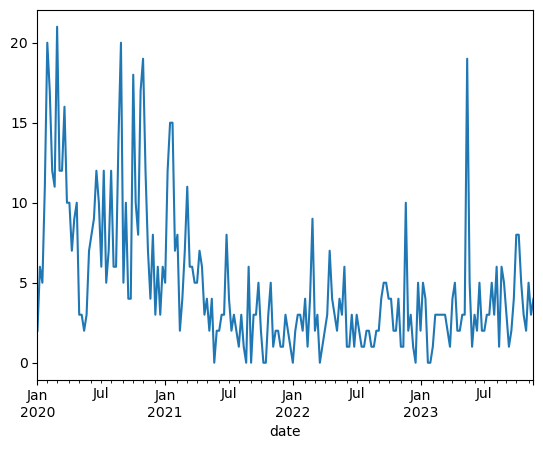

In [ ]:
counts['leadparagraph'].plot()

In [ ]:
def count_words(lead_paragraph) :
    splitted_text = lead_paragraph.split(" ")
    return len(splitted_text)

In [ ]:
corpus['words_count'] = corpus['leadparagraph'].apply(count_words)

In [ ]:
mean_words = corpus['words_count'].resample("W").mean().fillna(0)

In [ ]:
mean_words

date
2020-01-05 00:00:00+00:00    60.000000
2020-01-12 00:00:00+00:00    40.833333
2020-01-19 00:00:00+00:00    42.600000
2020-01-26 00:00:00+00:00    42.727273
2020-02-02 00:00:00+00:00    39.150000
                               ...    
2023-10-22 00:00:00+00:00    17.666667
2023-10-29 00:00:00+00:00    25.500000
2023-11-05 00:00:00+00:00    40.800000
2023-11-12 00:00:00+00:00    35.666667
2023-11-19 00:00:00+00:00    38.500000
Freq: W-SUN, Name: words_count, Length: 203, dtype: float64

<Axes: xlabel='date'>

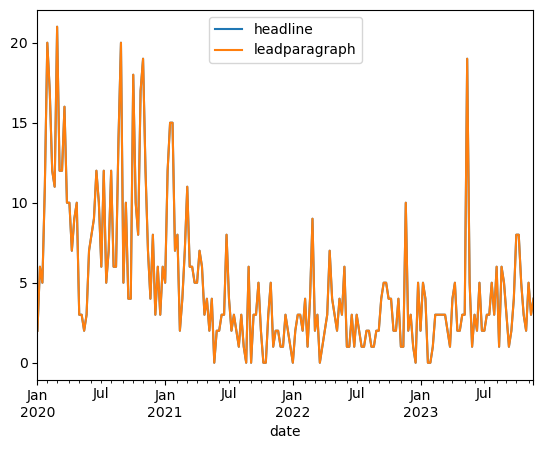

In [ ]:
counts.plot()

<Axes: xlabel='date'>

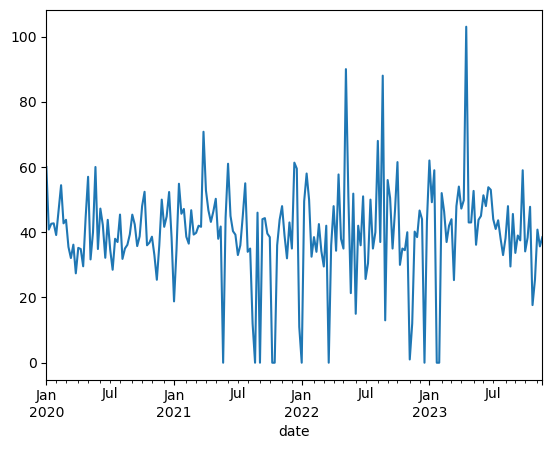

In [ ]:
#plot the average number of words per week
mean_words.plot()

In [ ]:
temp = corpus.copy()

def count_word(temp, string):
    temp['date'] = pd.to_datetime(corpus['date'])
    temp.set_index('date', inplace=True)

    count_specific_word = lambda words: words.lower().split().count(string.lower())
    temp['n_specific_words'] = temp['leadparagraph'].apply(count_specific_word)

    weekly_counts = temp['n_specific_words'].resample('W').sum()

    plt.figure(figsize=(10, 5))
    weekly_counts.plot()
    plt.title(f'Weekly Frequency Evolution of the word "{string}"')
    plt.xlabel('Date')
    plt.ylabel(f'Number of usage of the word "{string}"')
    plt.grid(True)
    plt.show()

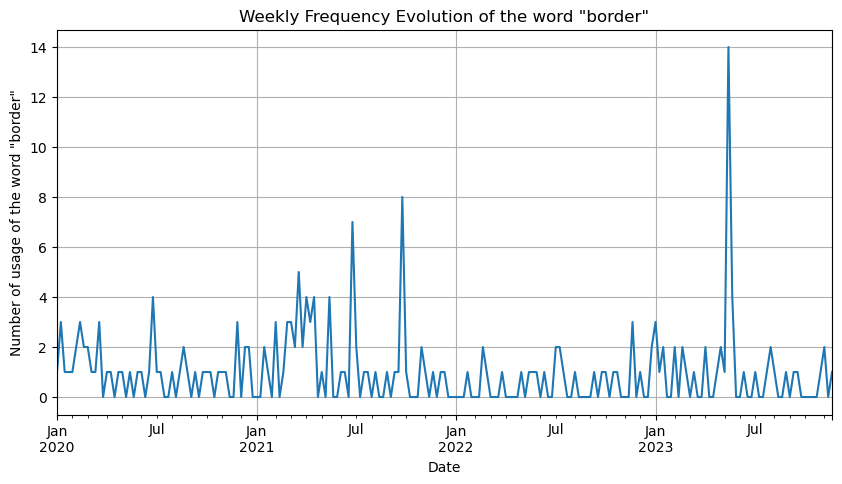

In [ ]:
count_word(temp, 'border')

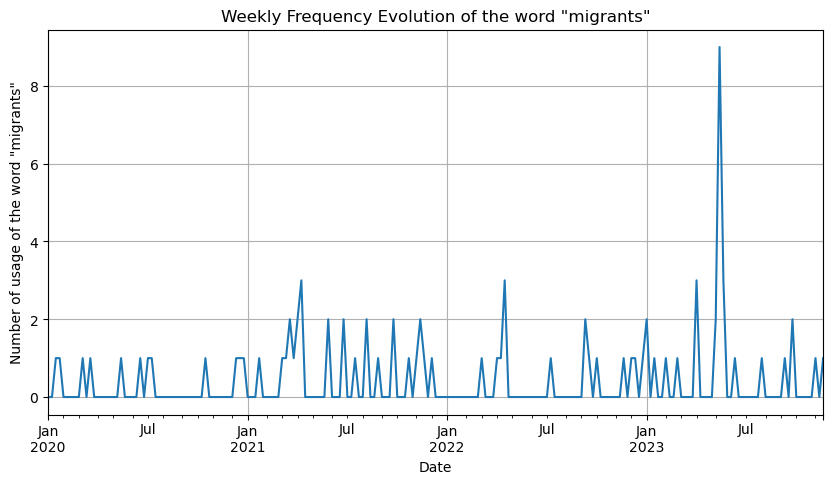

In [ ]:
count_word(temp, 'migrants')

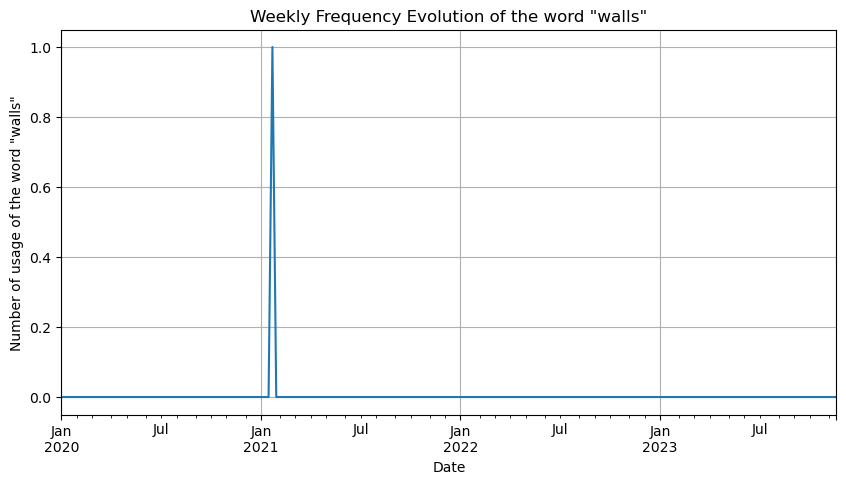

In [ ]:
count_word(temp, 'walls')

In [ ]:
## Choose a few words, plot their frequency evolution and comment.
# The words chosen are 'borders', 'migrants', and 'walls'. By looking at the frequency evolution of these words, it is shown that the word 'border' is often used, while the physical border in the form of 'walls' are not used that often, only in January 2021 when Trump inaugurated the US-Mexico border wall in Texas.
# As for the word 'migrants', it is being used fairly often with the most frequent being on May-June 2023, which shows how Trump's previous border policies have impacted migrants greatly, especially during these months when there was a surge of migrants from Latin America to the U.S.

## Topic Modeling

📊 Build a topic model using your corpus. You are free to choose the number of topics.
- Display the topics compisition and give them a label
- Suggest a global interpretation of the topic structure
- Take one topic and show the 3 most pertinent documents pertinent for this topic
- Choose two topics and define a metrics that allows you to identify the 3 documents which best fit those two topics.

In [ ]:
corpus = pd.read_csv("Documents/Master en France/Sciences Po/my_corpus.csv")

In [ ]:
corpus['full_text']=corpus['headline']+corpus['leadparagraph']

In [ ]:
corpus.dropna(subset=['leadparagraph'],inplace=True)

In [ ]:
corpus['length'] = corpus['full_text'].apply(len)

In [ ]:
corpus['length'].describe()

count     992.000000
mean      317.936492
std       119.917374
min        81.000000
25%       250.750000
50%       322.000000
75%       379.000000
max      1306.000000
Name: length, dtype: float64

In [ ]:
corpus

,headline,leadparagraph,date,words_count,full_text,length
0,Trumpism Without Borders,America is embedded in a world that is trouble...,2021-06-16 09:02:41+00:00,43,Trumpism Without BordersAmerica is embedded in...,315
1,Trump: Closing Borders Will Reduce ‘Mass Globa...,The U.S. Coronavirus Task Force held a news co...,2020-03-20 15:30:52+00:00,27,Trump: Closing Borders Will Reduce ‘Mass Globa...,229
2,Biden faces pressure to stop Trump-era border ...,President Biden is coming under increasing pre...,2021-05-25 12:29:22+00:00,43,Biden faces pressure to stop Trump-era border ...,349
3,Biden Administration Forces Out Trump-Era Bord...,WASHINGTON — The Biden administration is forci...,2021-06-24 01:47:51+00:00,41,Biden Administration Forces Out Trump-Era Bord...,314
4,Trump-Era Border Restrictions Are in Place as ...,WASHINGTON — One of the most expansive immigra...,2022-12-20 22:25:10+00:00,43,Trump-Era Border Restrictions Are in Place as ...,370
...,...,...,...,...,...,...
995,Trump Signs $2 Trillion Bill as U.S. Virus Cas...,Read about the latest developments in the coro...,2020-03-27 04:03:53+00:00,10,Trump Signs $2 Trillion Bill as U.S. Virus Cas...,129
996,"In Another Reversal, Biden Raises Limit on Num...",WASHINGTON — President Biden on Monday reverse...,2021-05-04 01:14:07+00:00,48,"In Another Reversal, Biden Raises Limit on Num...",377
997,Solo Soulless Saboteurs,"WASHINGTON — In the internet age, it’s almost ...",2022-09-24 13:18:44+00:00,17,Solo Soulless SaboteursWASHINGTON — In the int...,126
998,"After Calling Foes ‘Vermin,’ Trump Campaign Wa...",Former President Donald J. Trump’s campaign re...,2023-11-13 22:07:03+00:00,57,"After Calling Foes ‘Vermin,’ Trump Campaign Wa...",426


In [ ]:
articles[0]['keywords']

[{'name': 'subject',
  'value': 'United States Economy',
  'rank': 1,
  'major': 'N'},
 {'name': 'subject',
  'value': 'Politics and Government',
  'rank': 2,
  'major': 'N'},
 {'name': 'subject', 'value': 'Income Inequality', 'rank': 3, 'major': 'N'},
 {'name': 'subject',
  'value': 'National Intelligence Estimates',
  'rank': 4,
  'major': 'N'},
 {'name': 'subject',
  'value': 'United States Politics and Government',
  'rank': 5,
  'major': 'N'},
 {'name': 'subject',
  'value': 'Coronavirus (2019-nCoV)',
  'rank': 6,
  'major': 'N'},
 {'name': 'persons', 'value': 'Biden, Joseph R Jr', 'rank': 7, 'major': 'N'},
 {'name': 'persons', 'value': 'Trump, Donald J', 'rank': 8, 'major': 'N'}]

In [ ]:
for keyword in articles[0]['keywords']:
    if keyword['name']=='subject':
        print(keyword['value'])

United States Economy
Politics and Government
Income Inequality
National Intelligence Estimates
United States Politics and Government
Coronavirus (2019-nCoV)


In [ ]:
for article in articles:
    print (article['headline']['main'])

Trumpism Without Borders
Trump: Closing Borders Will Reduce ‘Mass Global Migration’
Biden faces pressure to stop Trump-era border expulsions.
Biden Administration Forces Out Trump-Era Border Patrol Chief
Trump-Era Border Restrictions Are in Place as Lawsuits Reach Supreme Court
Trump’s Pentagon Chief Quashed Idea to Send 250,000 Troops to the Border
Citing Coronavirus, Trump Will Announce Strict New Border Controls
Biden slams Trump over migrant family separations at the border.
Trump visits the border and falsely claims he was months from completing a wall.
It’s Time for Biden to Out-Trump Trump on Immigration
Texas Governor Endorses Trump, Lauding His Border Policies
In an Arizona border city, no Biden but long memories on Trump.
Biden Says He Cannot Quickly Undo Trump Border Policies
Trump and Aides Drove Family Separation at Border, Documents Say
5 Moments That Defined Trump’s Record on Immigration
Not Your Usual Police Chief: Biden Picks Trump Critic to Run Border Agency
Biden See

In [ ]:
corpus_text = corpus.full_text.values

In [ ]:
nlp = spacy.load("en_core_web_sm")
documents_nlp = []
for d in tqdm.tqdm(nlp.pipe(corpus_text,n_process=5),total=len(corpus_text)):
    documents_nlp.append(d)

100%|████████████████████████████████████████| 992/992 [00:09<00:00, 108.06it/s]


In [ ]:
for token in documents_nlp[0]:
    print(token)

Trumpism
Without
BordersAmerica
is
embedded
in
a
world
that
is
troubled
by
insidious
parallel
variants
of
the
same
structural
problems
—
anti
-
immigrant
fervor
,
political
tribalism
,
racism
,
ethnic
tension
,
authoritarianism
and
inequality
—
that
led
to
a
right
-
wing
takeover
of
the
federal
government
by
Donald
Trump
.


In [ ]:
docs = [[token.lemma_.lower() for token in doc if  token.is_alpha] for doc in documents_nlp]

In [ ]:
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [ ]:
id2word = Dictionary(docs)
id2word.filter_extremes(no_below=20, no_above=0.1)

corp = corpus.copy()
# create corpus
corpus = [id2word.doc2bow(text) for text in docs]

In [ ]:
corp

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)],
 [(5, 1),
  (13, 1),
  (14, 1),
  (15, 2),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1)],
 [(9, 1),
  (14, 1),
  (15, 1),
  (20, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 2),
  (32, 2),
  (33, 1),
  (34, 1),
  (35, 1)],
 [(5, 1),
  (9, 1),
  (15, 1),
  (18, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 2),
  (44, 2),
  (45, 1),
  (46, 1)],
 [(27, 1), (47, 1), (48, 1)],
 [(7, 1),
  (20, 1),
  (32, 1),
  (45, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1)],
 [(12, 1),
  (17, 2),
  (54, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1)],
 [(14, 1),
  (18, 1),
  (35, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),

In [ ]:
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=5,
                   passes=20)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
cm.get_coherence()

-4.735870884406156

In [ ]:
docs_2_topics = lda_model[corpus]
docs_2_topics[24]

[(0, 0.8992035),
 (1, 0.025137076),
 (2, 0.025098361),
 (3, 0.025317827),
 (4, 0.025243219)]

In [ ]:
docs_2_topics

In [ ]:
label_dict = {i: ', '.join([token for token, score in lda_model.show_topic(i, topn=10)]) for i in range(0, lda_model.num_topics)}
for topic in label_dict:
    print (topic,':\t', label_dict[topic])

0 :	 here, security, up, our, homeland, sign, your, live, briefing, department
1 :	 court, mexico, federal, pandemic, policy, asylum, american, end, most, health
2 :	 we, presidential, right, now, night, you, get, let, desantis, do
3 :	 house, white, their, party, state, republicans, york, capitol, times, would
4 :	 last, do, day, what, week, texas, month, she, go, how


In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, id2word,sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.245193  0.028253       1        1  11.459440
1      0.009430 -0.153473       2        1  24.581376
2      0.084342  0.121142       3        1  20.439888
3      0.061671  0.078662       4        1  22.214550
4      0.089750 -0.074583       5        1  21.304747, topic_info=         Term        Freq       Total Category  logprob  loglift
98      house  116.000000  116.000000  Default  30.0000  30.0000
87       here   74.000000   74.000000  Default  29.0000  29.0000
33   security   58.000000   58.000000  Default  28.0000  28.0000
0     federal   69.000000   69.000000  Default  27.0000  27.0000
78        our   70.000000   70.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
66       more   26.219051  101.512040   Topic5  -4.5556   0.1925
130     first   23.695682   95.641404   Topic5  -4.6568   0.1509
68       than   22.619145   73.386150   Topic5  -4.7032   0.3693
104   country   21.444471   64.646047   Topic5  -4.7566   0.4428
31        out   21.445984   80.931821   Topic5  -4.7565   0.2182

[247 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
161       2  0.550709   across
161       4  0.103258   across
161       5  0.309774   across
119       1  0.257513  against
119       2  0.114450  against
...     ...       ...      ...
178       2  0.014661      you
178       3  0.586444      you
178       5  0.395850      you
110       1  0.852910     your
110       3  0.138310     your

[657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [ ]:
# Display the topics composition and give them a label

num_topics = 5
topic_labels = {
    0: 'Government',
    1: 'Immigration',
    2: 'Border',
    3: 'Trump',
    4: 'Immigrant'}
topic_keywords = {
    'Government': ['policy', 'asylum', 'court'],
    'Immigration': ['security', 'patrol', 'law'],
    'Border': ['presidential', 'pandemic', 'southwestern'],
    'Trump': ['state', 'republicans', 'house'],
    'Immigrant': ['country', 'people', 'american'] }

#display the 5 topics dispotition
for topic_idx in range(num_topics):
    print(f"\nTopic {topic_idx + 1} ({topic_labels[topic_idx]}):")


Topic 1 (Government):

Topic 2 (Immigration):

Topic 3 (Border):

Topic 4 (Trump):

Topic 5 (Immigrant):


In [ ]:
## Suggest a global interpretation of the topic structure
# Based on the topic structure, from the relevant words of each topic, we could infer that the discourse within Trump and Border revolves around the U.S. government, immigration, border, Trump's presidency and immigrant.


In [ ]:
## Take one topic and show the 3 most pertinent documents pertinent for this topic

selected_topic = 4

topic_distribution = lda_model.get_document_topics(corpus)

pertinent_docs = []
for i, doc_topics in enumerate(topic_distribution):
    for topic_num, prop_topic in doc_topics:
        if topic_num == selected_topic:
            pertinent_docs.append((i, prop_topic))

pertinent_docs = sorted(pertinent_docs, key=lambda x: x[1], reverse=True)

top_docs_indices = [doc[0] for doc in pertinent_docs[:3]]
top_docs = [(corp.loc[idx][0], corp.loc[idx][1], corp.loc[idx][2]) for idx in top_docs_indices]

/var/folders/qp/8_qg97kd7bdbttdk0z9nv0z00000gn/T/ipykernel_46685/4130340984.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top_docs = [(corp.loc[idx][0], corp.loc[idx][1], corp.loc[idx][2]) for idx in top_docs_indices]


In [ ]:
top_docs

[('Biden Administration Considers Migrant Restrictions Similar to Trump Policies',
  'WASHINGTON — The Biden administration is considering substantial new limits on the number of migrants who could apply for asylum in the United States, according to people familiar with the proposal, which would expand restrictions similar to those first put in place along the border by former President Donald J. Trump.',
  '2022-12-01 21:31:15+00:00'),
 ('Trump stages his own ‘State of the Union’ speech.',
  'Eager to burnish his 2024 bona fides as some Republicans raise doubts about his third bid for the White House, former President Donald J. Trump stood Tuesday between two American flags — in his signature blue suit and red tie — and offered his own assessment of the nation.',
  '2023-02-08 05:22:51+00:00'),
 ('What Was Donald Trump’s Twitter?',
  'Each of the big social platforms handled the challenges of the Trump presidency in its own unique way, scrambling to address or neutralize various urgen

In [ ]:
## Choose two topics and define a metrics that allows you to identify the 3 documents which best fit those two topics.

# Selected topics
topic_a = 1
topic_b = 3

# Calculate the relevance metric for each document
doc_scores = []
for doc_id, doc_topics in enumerate(lda_model.get_document_topics(corpus)):
    pA, pB = 0, 0
    for topic_num, prop_topic in doc_topics:
        if topic_num == topic_a:
            pA = prop_topic
        elif topic_num == topic_b:
            pB = prop_topic
    score = pA * pB  # or (pA + pB) / 2 for average
    doc_scores.append((doc_id, score))

# Sort by the metric and select the top 3 documents
top_docs_indices = sorted(doc_scores, key=lambda x: x[1], reverse=True)[:3]
top_docs = [(corp.loc[idx[0]][0], corp.loc[idx[0]][1], corp.loc[idx[0]][2]) for idx in top_docs_indices]
top_docs

/var/folders/qp/8_qg97kd7bdbttdk0z9nv0z00000gn/T/ipykernel_46685/881773854.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top_docs = [(corp.loc[idx[0]][0], corp.loc[idx[0]][1], corp.loc[idx[0]][2]) for idx in top_docs_indices]


[('Appeals Court Rejects Trump’s Diversion of Military Funds for Border Wall',
  'WASHINGTON — A federal appeals court in San Francisco ruled on Friday that the Trump administration did not have the authority to transfer $2.5 billion from the Pentagon to President Trump’s border wall without congressional approval, most likely sending the matter to the Supreme Court.',
  '2020-06-26 22:05:49+00:00'),
 ('Biden faces pressure to stop Trump-era border expulsions.',
  'President Biden is coming under increasing pressure to abandon a Trump-era immigration rule that has sealed off the United States to most migrants during the pandemic, with human rights officials and two of the administration’s own medical consultants saying it endangers vulnerable families.',
  '2021-05-25 12:29:22+00:00'),
 ('Trump, His Eye on the Border, Overlooked the Coronavirus Threat',
  'On Jan. 20, the federal Centers for Disease Control and Prevention found for the first time that the Covid-19 coronavirus had infec

dfcdfondfokdsnodcnkodondnocnkdnkocxxvcnk

---